<h1>Finetuning BERT model<h1>
    <h5>In this notebook, we classify our tweets by finetuning pre-trained BERT model with our tweet data<h5>

In [1]:
#importing libraries
import pandas as pd
import dill
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import transformers
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

2023-08-14 12:52:51.539488: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
#helper function to generate performance report
def performance(y_true,y_predict,y_proba=[]):
    TP = confusion_matrix(y_true,y_predict)[0,0]
    FP = confusion_matrix(y_true,y_predict)[0,1]
    TN = confusion_matrix(y_true,y_predict)[1,1]
    FN = confusion_matrix(y_true,y_predict)[1,0]
    TN, FP, FN, TP = confusion_matrix(y_true,y_predict).ravel()
    print(f"Accuracy: {round(((TP+TN)/(TP+TN+FP+FN))*100,3)}%")
    precision = round((TP/(TP+ FP))*100,3)
    recall = round((TP/(TP+ FN))*100,3)
    print(confusion_matrix(y_true,y_predict,labels=[1,0]).ravel())
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"TN: {TN}")
    print(f"FN: {FN}")
    print(f"Sensitivity: {round((TP/(TP+ FN))*100,3)}%")
    print(f"Specificity: {round((TN/(TN + FP))*100,3)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"f1: {round(((2*precision*recall)/(precision+recall)),3)}%")
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict,labels=[1,0]), display_labels=[1,0])
    cm_display.plot()
    plt.show()
    if (y_proba!=[]):
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true,y_proba)
        print(thresholds)
        area = metrics.auc(false_positive_rate, true_positive_rate)
        plt.figure()
        plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, label=f'ROC curve (Area Under Curve = {area:.2f})')
        plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

In [16]:
#load raw tweets
train_df = pd.read_pickle('../train_df.pkl')
test_df = pd.read_pickle('../test_df.pkl')

In [2]:
#load cleaned tweets
train_df_cleaned = pd.read_pickle('./train_df_cleaned.pkl')
test_df_cleaned = pd.read_pickle('./test_df_cleaned.pkl')

In [17]:
#convert pandas dataframe into a dataset dictionary for ease of tokenization
train_df = Dataset.from_pandas(train_df)
test_df = Dataset.from_pandas(test_df)

In [3]:
#convert pandas dataframe into a dataset dictionary for ease of tokenization
train_df_cleaned = Dataset.from_pandas(train_df_cleaned)
test_df_cleaned = Dataset.from_pandas(test_df_cleaned)

In [8]:
train_df

Dataset({
    features: ['level_0', 'index', 'author_id', 'geo', 'tweetid', 'lang', 'like_count', 'quote_count', 'reply_count', 'retweet_count', 'tweet_original', 'context', 'sensitive', 'created_at', 'ccs_score', 'rowid', 'relevant_manualscore', 'related_score_based', 'tweet_preprocessed', 'tweet_tokenized_original', 'tweet_tokenized_preprocessed', 'tweet_word2vec_original', 'tweet_word2vec_preprocessed', 'context_domain_name', 'related_manual', 'context_word2vec'],
    num_rows: 2000
})

<h3>BERT<h3>
    <h5>First let us try with the raw tweets<h5>

In [24]:
#initialise bert tokenizer instance
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

In [25]:
#tokenize train and test datasets with bert tokenizer
tokenized_bert_train_data = tokenizer_bert(train_df["tweet_original"], return_tensors="np", padding=True)
tokenized_bert_test_data = tokenizer_bert(test_df["tweet_original"], return_tensors="np", padding=True)
labels_bert_train = np.array(train_df["related_manual"])
tokenized_bert_train_data = dict(tokenized_bert_train_data)
tokenized_bert_test_data = dict(tokenized_bert_test_data)

In [26]:
#initialise pretrained BERT model
model_bert = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model_bert.compile(optimizer=Adam(3e-5))

In [29]:
%%time
#finetune the BERT model using our dataset
model_bert.fit(tokenized_bert_train_data,labels_bert_train)

2023-08-07 06:36:42.807761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 06:36:44.872052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


63/63 [==============================] - 816s 12s/step - loss: 0.3590
CPU times: user 3min 3s, sys: 6min 5s, total: 9min 9s
Wall time: 13min 35s


In [30]:
%%time
#get the prediction logits
bert_preds = model_bert.predict(tokenized_bert_test_data)["logits"]

2023-08-07 06:50:05.295807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 40s 2s/step
CPU times: user 29.9 s, sys: 5.87 s, total: 35.7 s
Wall time: 40 s


In [31]:
#convert into binary class predictions
class_bert_preds = np.argmax(bert_preds, axis=1)

In [21]:
bert_preds

array([[-1.6983091 ,  1.1880945 ],
       [ 1.9365022 , -2.0599244 ],
       [ 1.9409713 , -2.1222336 ],
       [-2.0236485 ,  1.6883504 ],
       [-2.0725863 ,  1.599599  ],
       [ 2.06329   , -2.20838   ],
       [ 1.6203303 , -1.6624464 ],
       [-1.6008744 ,  1.0763496 ],
       [ 2.027021  , -2.2215617 ],
       [-2.1029873 ,  1.6907939 ],
       [ 0.80641973, -0.98727083],
       [ 2.0153155 , -2.0600386 ],
       [ 1.1108552 , -1.2284294 ],
       [-2.0161135 ,  1.6090947 ],
       [ 1.8132471 , -1.792389  ],
       [ 1.9996723 , -2.084376  ],
       [ 2.050748  , -2.1990292 ],
       [ 2.0129514 , -2.1970966 ],
       [ 2.0797064 , -2.2599578 ],
       [ 1.4524599 , -1.409375  ],
       [ 1.8321518 , -1.8123285 ],
       [-1.6755092 ,  1.1663233 ],
       [-1.9740106 ,  1.5091244 ],
       [-2.0717707 ,  1.6334208 ],
       [-2.0059135 ,  1.7494272 ],
       [ 2.0101402 , -2.1600718 ],
       [ 1.5767913 , -1.5273606 ],
       [-1.9869013 ,  1.5278081 ],
       [-1.947399  ,

Accuracy: 95.8%
[250   0  21 229]
TP: 250
FP: 21
TN: 229
FN: 0
Sensitivity: 100.0%
Specificity: 91.6%
Precision: 92.251%
Recall: 100.0%
f1: 95.969%


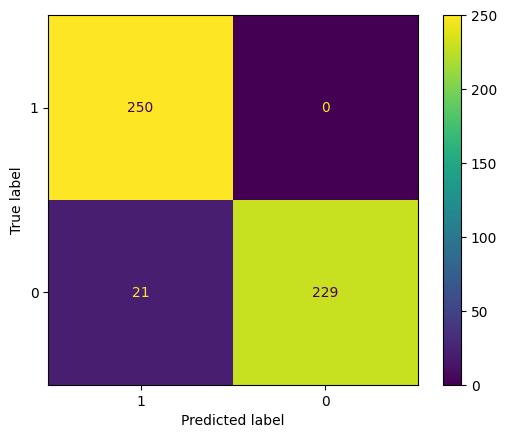

In [32]:
#generate performance report
performance(test_df['related_manual'],class_bert_preds)

<h5>Now, let us repeat the same experiments with Cleaned tweets<h5>

In [4]:

tokenizer_bert_cleaned = AutoTokenizer.from_pretrained("bert-base-uncased")

In [6]:
tokenized_bert_train_data_cleaned = tokenizer_bert_cleaned(train_df_cleaned["tweet_preprocessed"], return_tensors="np", padding=True)
tokenized_bert_test_data_cleaned = tokenizer_bert_cleaned(test_df_cleaned["tweet_preprocessed"], return_tensors="np", padding=True)
labels_bert_train_cleaned = np.array(train_df_cleaned["related_manual"])
tokenized_bert_train_data_cleaned = dict(tokenized_bert_train_data_cleaned)
tokenized_bert_test_data_cleaned = dict(tokenized_bert_test_data_cleaned)

In [7]:
model_bert_cleaned = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

2023-08-14 12:56:40.034250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-14 12:56:40.034312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model_bert_cleaned.compile(optimizer=Adam(3e-5))

In [9]:
%%time
model_bert_cleaned.fit(tokenized_bert_train_data_cleaned,labels_bert_train_cleaned)

2023-08-14 12:57:18.490818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 12:57:20.631545: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


63/63 [==============================] - 161s 2s/step - loss: 0.3549
CPU times: user 1min 42s, sys: 41.4 s, total: 2min 23s
Wall time: 2min 42s


In [10]:
%%time
bert_preds_cleaned = model_bert_cleaned.predict(tokenized_bert_test_data_cleaned)["logits"]

2023-08-14 13:01:10.700826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 26s 1s/step
CPU times: user 19.2 s, sys: 4.41 s, total: 23.6 s
Wall time: 27.1 s


In [11]:
class_bert_preds_cleaned = np.argmax(bert_preds_cleaned, axis=1)

Accuracy: 94.2%
[244   6  23 227]
TP: 244
FP: 23
TN: 227
FN: 6
Sensitivity: 97.6%
Specificity: 90.8%
Precision: 91.386%
Recall: 97.6%
f1: 94.391%


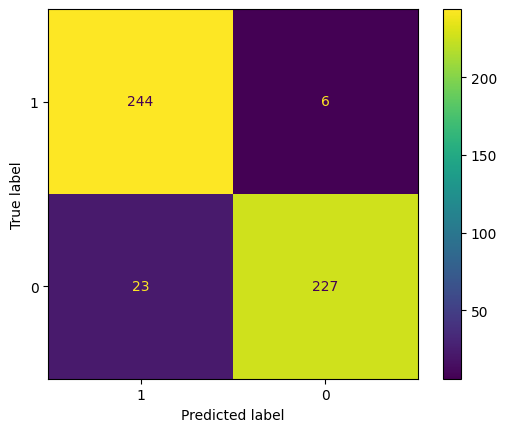

In [14]:
performance(test_df_cleaned['related_manual'],class_bert_preds_cleaned)

<h2>Results<h2>
    <h5>Clearly, the model performed better when finetuned with raw tweets. Which means BERT is effective in learning deep contextual represntations of sentences<h5>

| Model | Accuracy | TP  | FP | TN  | FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|-------|----------|-----|----|-----|----|-------------|-------------|-----------|--------|----------|
| BERT  | 95.8%    | 250 | 21 | 229 | 0  | 100.0%      | 91.6%       | 92.251%   | 100.0% | 95.969%  |